Unesite velicinu za kvadratnu matricu sa kojom zelite igru: 8
Unesite broj iteracija koliko: 40
[[1 1 0 1 0 0 1 0]
 [0 1 1 0 0 0 1 0]
 [1 1 0 0 0 0 0 0]
 [1 0 1 0 0 0 1 0]
 [0 0 1 1 1 1 0 0]
 [0 1 0 1 0 1 0 1]
 [0 1 0 0 1 0 1 0]
 [0 1 0 1 1 0 0 0]]


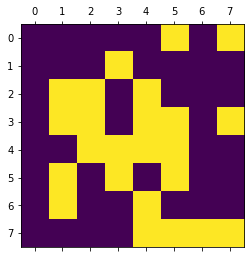

In [11]:
import numpy as np
import threading 
from queue import Queue, Empty
#importi za animaciju
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

brIteracija = 0
n = 0
matrix = []
velMatrice = 0
matrix_kljuc = threading.Lock()
obradjenaPolja_kljuc = threading.Lock()
promenaIteracije_kljuc = threading.Lock()
prviRed = Queue(1)
prviRed.put(1)
# drugiRed.put(1)
redniBrojIteracije = 0
brIteracija = 0
brojacObradjenihPolja = 0
nizIteracija = list()
# nizIteracija.append([])
threads = []


# funkcija koju prosledjujem tredovima kad ih kreiram
# funkcija radi sa pozicijom polja (i,j)
def proveriZaPolje(i,j):
    # print(f"usao u tred za vrednosti {i} i {j}")
    global matricaRedova
    global matrix
    global n
    global velMatrice
    global brIteracija
    global redniBrojIteracije
    global brojacObradjenihPolja
    global prviRed
    global drugiRed
    global matrix_kljuc 
    global obradjenaPolja_kljuc
    global promenaIteracije_kljuc
    
    #ne treba, svakako cu u foru postavljati
    # matrix_kljuc.acquire()
    # staraVrednostPolja = matrix[i][j]
    # matrix_kljuc.release()


    # prolazim onoliko puta koliko je korisnik uneo da zeli da ima iteracija
    # i u redove svih mojih suseda ubacim, svoju staru(za sada jos uvek trenutnu) vrednost
    # ubacujem te vrednosti preko matrice redova koja mi je "mapirana" da se poklapa sa vrednostima i velicinom matrice
    # tj jedno polje u matrixu, ima svoj red u matriciRedova na istoj poziciji
    for k in range(brIteracija):
        while(prviRed.qsize()==0):
            continue
        # print(f"nit je u novoj iteraciji {k} i redniBrojIteracije je {redniBrojIteracije} ")
        # pokupim staru vrednost polja(i,j) iz trenutne matrice 
        matrix_kljuc.acquire()
        staraVrednostPolja = matrix[i][j]
        matrix_kljuc.release()
        for i1 in range(i-1, i+2):
            for j1 in range(j-1, j+2):
                if(i1==i and j1==j):
                    continue;
                matricaRedova[i1%n][j1%n].put(staraVrednostPolja)

        brojZivihSuseda = 0

       
        # uzimam vrednosti iz svoga reda i 
        # prebrojevam koliko imam zivih suseda
        for p in range(8):
            try:
                vrednostSuseda = matricaRedova[i][j].get()
                if vrednostSuseda == 1:
                    brojZivihSuseda+=1
                # matricaRedova[i][j].task_done()
            except Empty:
                break

        # proveravam da li u sledecoj iteraciji trenutno polje treba da bude zivo ili mrtvo
        if(brojZivihSuseda<2):
                (nizIteracija[redniBrojIteracije])[i][j]=0
        elif(brojZivihSuseda>3):
                (nizIteracija[redniBrojIteracije])[i][j]=0
        elif(staraVrednostPolja == 1 and (brojZivihSuseda==2 or brojZivihSuseda==3)):
                (nizIteracija[redniBrojIteracije])[i][j]=1
        elif(staraVrednostPolja == 0 and brojZivihSuseda==3):
                (nizIteracija[redniBrojIteracije])[i][j]=1
        
        # napravila sam kao atomicnu funkciju tako da se i brojac povecava i da njegovu vrednost dodeljujem nekoj lokalnoj prom koja ce mi sluziti za proveravanje u ifu
        obradjenaPolja_kljuc.acquire()
        brojacObradjenihPolja +=1
        mojBrojacObradjenihPolja = brojacObradjenihPolja
        obradjenaPolja_kljuc.release()

        # print(f"k nam je {k} i mojBrojacObradjenihPolja je {mojBrojacObradjenihPolja}")
        # proveravam da li je poslednja nit za tu iteraciju u pitanju, tako sto proverim da li mi je brojac jednak velicini matrice
        if(mojBrojacObradjenihPolja==velMatrice):
            # ovo mi osigurava da mi niko ne utrci u put za prvired dok se nije putovalo velMatrice-1 vrednosti,
            #  tj dok nisam obisla svako pojedinacno polje, osim poslednjeg za koji sam usla u ovaj if
            while(drugiRed.qsize() < velMatrice-1):
                continue;
            # postavljam koja mi je trenutna matrica sa kojom radim
            #  povecavam redniBrojIteracije za jedan i brojacObradjenih obaram na 0,jer sam obisla jednu celu matricu
            # i sad spremam te promenljive za ulaz u sledecu iteraciju
            matrix = np.copy(nizIteracija[redniBrojIteracije])
            promenaIteracije_kljuc.acquire()
            redniBrojIteracije +=1
            promenaIteracije_kljuc.release()
            obradjenaPolja_kljuc.acquire()
            brojacObradjenihPolja = 0
            obradjenaPolja_kljuc.release()
            # prvi red mi je velicine 1, tako da ovaj get ce pokupiti tu vrednost i zatim ce se pozvati taskdone, koji treba da odblokira join iz elsa nad ovim redom
            prviRed.get()
            prviRed.task_done()
            # print(f"k je {k}, a redniBrojIteracije je {redniBrojIteracije}")
            # ovde blokiram drugi red sve dok mi se ne uradi get za velMat-1 polja i na taj nacin, zbog while na pocetku ifa, 
            # ne dozvoljavam nikada da se nesto putuje u prviRed dok se nad prethodnom iteracijom nije pozvao join, jer kada bi neko uleteo i uradio put pre nego sto se odblokira join, dobila bih deadlock 
            drugiRed.join()
            # tako da putujem tek nakon sto se obisla jedna cela matrica i nad njom pozvao join
            prviRed.put(1)
            # print(f"prvi red put {prviRed.qsize()}")
        else:
            # za svako polje osim poslednjeg(ne po poziciji, nnego po brojacu) putujem jednu vrednost u drugiRed
            drugiRed.put(1)
            # print(f"dodato u drugi red za iteraciju {k} i velicina prvog reda je {prviRed.qsize()}")
            # join blokira sve dok mu ne dodje taskdone da se obisla cela matrica
            prviRed.join()
            # getovanje i taskdoneovanje za drugi red radim ovde, tek posle joina za prvi red, jer mi drugi red obezbedjuje da ne moze da se izvrsi put u prvi red za sledecu iteraciju
            # dok se nije pozvao join nad prvim redom za prethodnu iteraciju
            drugiRed.get()
            drugiRed.task_done()
        


            
            
        # matricaRedova[i][j].join()

        

# samo kreira tredove za svako polje, pokrece i joinuje
def pokreniTredove():
    # threads = [threading.Thread(target=proveriZaPolje) for i in range(n*n)]
    global n
    global threads
    for i in range(n):
        for j in range(n):
            thread = threading.Thread(target=proveriZaPolje,args=(i,j))
            threads.append(thread)
    test=0
    for thread in threads:
        thread.start()
        test+=1
        # print(test)
    # print("svi tredovi su pokrenuti")
    # print(nizIteracija)
    for thread in threads:
        thread.join()
        # test+=1
        # print(test)
    # print(nizIteracija)




# da ne bih svaki put unosila matricu za testiranje
# n=5
#brIteracija = 10
# matrix = np.array([[0, 0, 0, 0, 0],
#                 [0, 0, 1, 0, 0],
#                 [0, 1, 1, 1, 0],
#                 [0, 0, 1, 0, 0],
#                 [0, 0, 0, 0, 0]])

n = int(input("Unesite velicinu za kvadratnu matricu sa kojom zelite igru: "))
brIteracija = int(input("Unesite broj iteracija koliko: "))

velMatrice = int(n*n)

# kreiram red velicine matrice za svaki slucaj, iako cu koristiti samo do velMatrice-1
drugiRed = Queue(velMatrice)

# za testiranje, da ne bih svaki put unosila svoju matricu
matrix = (np.array(np.random.rand(velMatrice)).reshape(n, n) > 0.5).astype(np.int8)
print(matrix)

# print("Moguce vrednosti za polja su 0(ukoliko je celija mrtva) i 1(ukoliko je celija ziva)" )
# print(f"Unesi vrednosti polja odvojenih razmakom(space-om), potrebno je da uneseti {velMatrice} brojeva: ")
# 
# # User input of entries in a 
# # single line separated by space
# entries = list(map(int, input().split()))
# 
# # For printing the matrix
# matrix = np.array(entries).reshape(n,n)

# postavljam prazne nizove u niz iteracija pa cu posle da ih menjam i ubacujem prave matrice u njega
# morala sam ovako jer me pajton zezao kad sam probala da apendujem nesto, ako vec nisam imala "vec prazno rezervisano mesto za to"
# tako da mi je na pocetku samo ceo niz setovan na pocetnu matricu
for i in range(brIteracija):
    pom = []
    matrica = np.array([[0 for j in range(n)] for x in range(n)])
    pom.append(matrica)
    nizIteracija.append(pom)
    nizIteracija[i] = np.copy(matrix)

# print(f"pre tredova {nizIteracija}")

# kreiram matricu redova odgovarajuce velicine, tj kao i unete matrice
matricaRedova = np.array([[Queue(8) for j in range(n)] for i in range(n)])


# pozivam za kreiranje i pokretanje tredova
pokreniTredove()



def animate(steps):
    ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
    prikazuje razvoj sistema'''
  
    def init():
        im.set_data(steps[0])
        return [im]
  
  
    def animate(i):
        im.set_data(steps[i])
        return [im]

    im = plt.matshow(steps[0], interpolation='None', animated=True);
  
    anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
    return anim


anim = animate(np.array(nizIteracija));
HTML(anim.to_html5_video())